In [1]:
import warnings
warnings.filterwarnings("ignore")

import snapatac2 as snap
import polars as pl
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
from magic import MAGIC
snap.__version__

'2.5.3'

In [2]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=700,
    facecolor="white",
    vector_friendly=False,
    frameon=False,
)

# Analyze E14.5 scATAC-seq pancreas data from this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC10230264/

In [4]:
%%time
# The on-memory approach for anndata object is used here, rather than the backed (on disk) mode. Please consult the SnapATAC2 tutorial page for more information. 
data = snap.pp.import_data(
    'GSM6432740_E14.5_Whole_fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 16min 37s, sys: 24.5 s, total: 17min 1s
Wall time: 5min 54s


AnnData object with n_obs × n_vars = 22116 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2025-05-11 17:06:24 - INFO - Computing fragment size distribution...


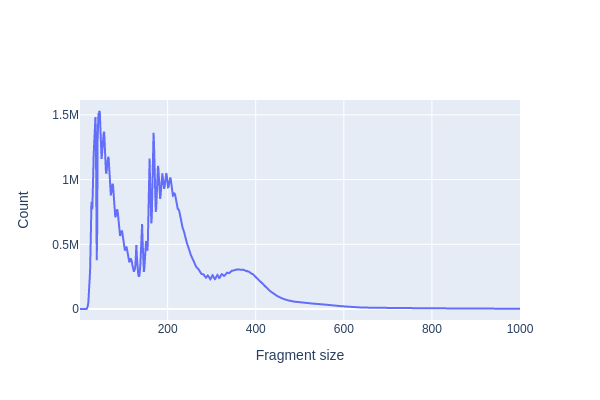

In [5]:
snap.pl.frag_size_distr(data, interactive=False)

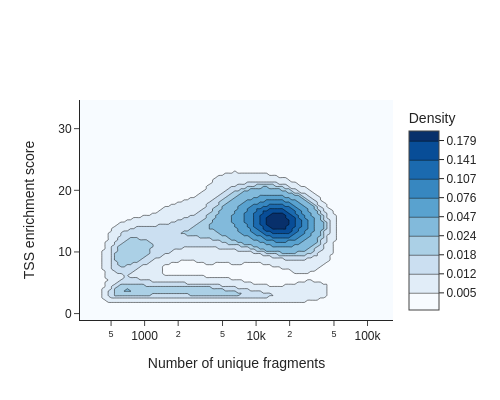

In [7]:
# Plot TSS enrichment scores against number of unique fragments of each cell
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [8]:
# Filter for high-quality barcodes using minimum counts (2000) and min TSS enrichment socres (7)
%%time
snap.pp.filter_cells(data, min_counts=2000, min_tsse=7, max_counts=100000)
data

CPU times: user 1.24 s, sys: 589 ms, total: 1.83 s
Wall time: 1.83 s


AnnData object with n_obs × n_vars = 14388 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [12]:
# Create a cell-by-bin matrix containing insertions across 500-bp bins, select accessible features excluding those overlapping blacklist, adn remove doublets
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2025-05-11 17:23:52 - INFO - Detected doublet rate = 10.585%


AnnData object with n_obs × n_vars = 12865 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

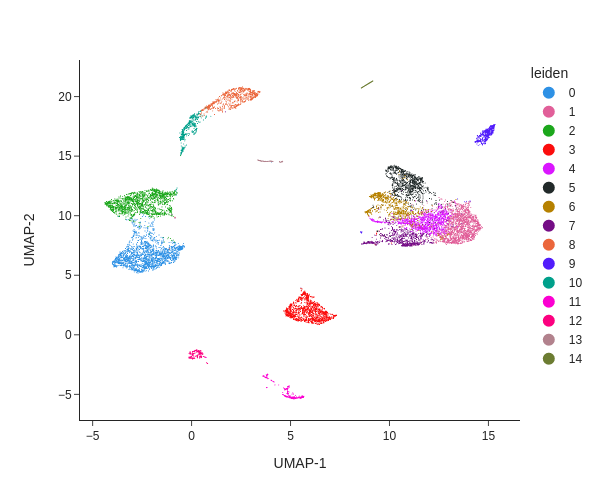

In [16]:
# Dimensional reduction using spectral embedding, perform UMAP, build a k-nearest neighbor graph, and perform Leiden clustering
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [19]:
# Create a cell-by-gene activity matrix. We are counting fragments but not reads to improve the quantitation of regulatory information. 
# Reference: https://www.nature.com/articles/s41592-023-02112-6
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)
gene_matrix

CPU times: user 4min 35s, sys: 5.31 s, total: 4min 40s
Wall time: 17.5 s


AnnData object with n_obs × n_vars = 12865 × 55291
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

... storing 'leiden' as categorical


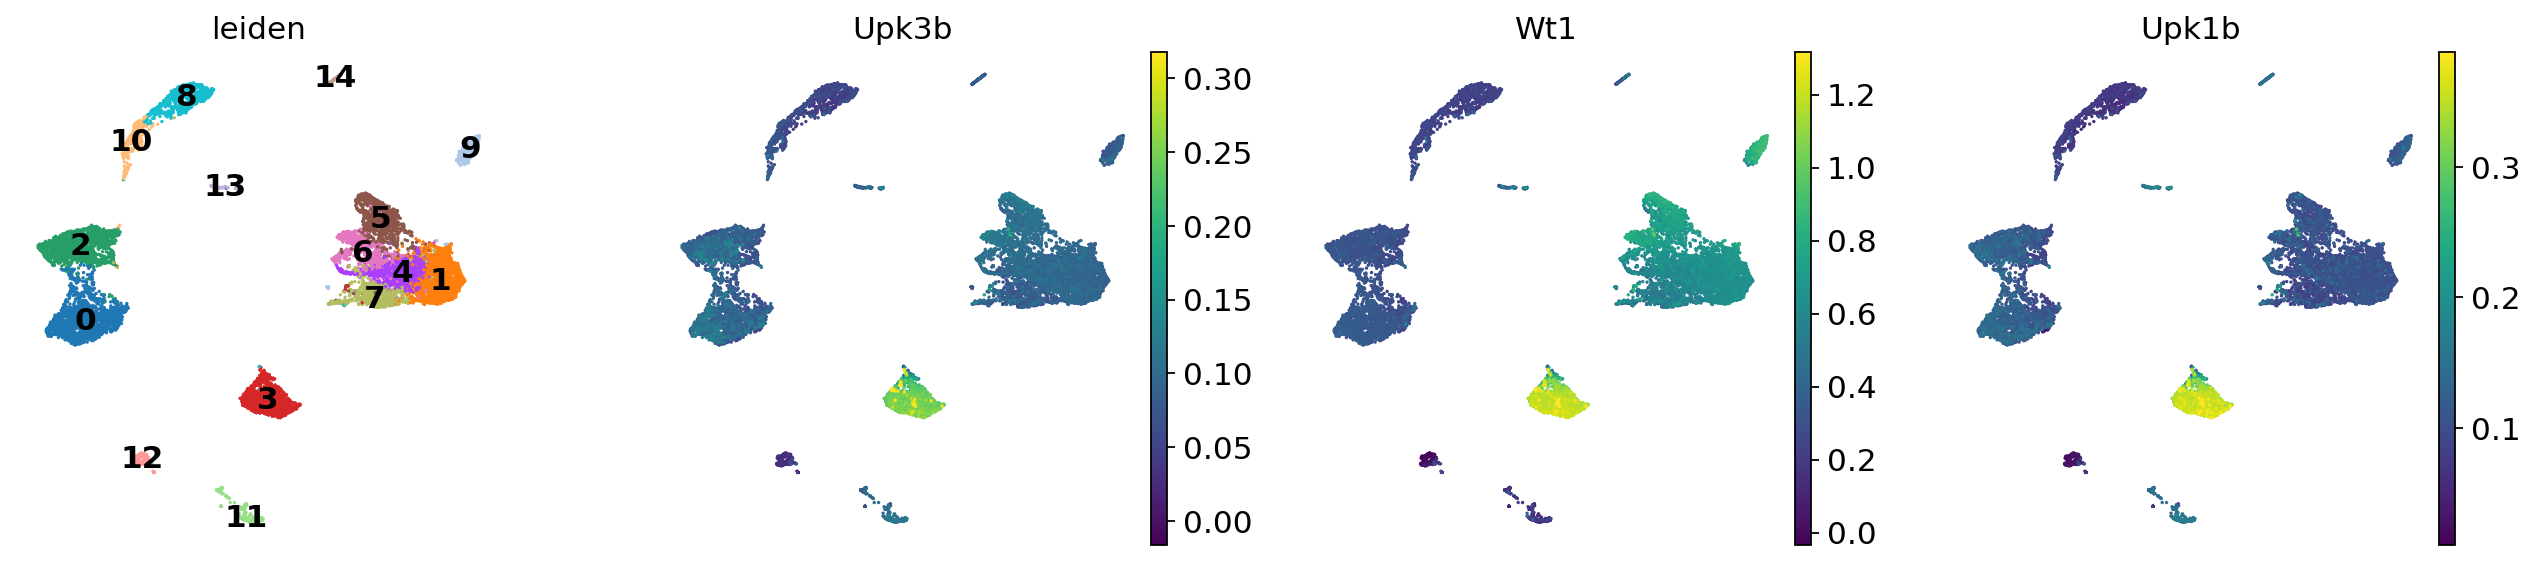

In [23]:
# Perform gene filtering, data normalization, data transformation, and then call the sc.external.pp.magic function to complete the imputation
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
marker_genes = ['Upk3b','Wt1','Upk1b']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data',save='mesothelial_markers.png')

In [27]:
# Cluster out the mesothelial cluster
meso = data[data.obs['leiden'].isin(['3'])]
meso

View of AnnData object with n_obs × n_vars = 1303 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [28]:
%%time
gene_matrix2 = snap.pp.make_gene_matrix(meso, snap.genome.mm10, count_frag_as_reads=False)
gene_matrix2

CPU times: user 32.7 s, sys: 1.87 s, total: 34.5 s
Wall time: 6.71 s


AnnData object with n_obs × n_vars = 1303 × 55291
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [29]:
%%time
sc.external.pp.magic(gene_matrix2, solver="approximate")

CPU times: user 57.3 s, sys: 3.3 s, total: 1min
Wall time: 12.2 s


In [33]:
gene_matrix2.write("mouse_e145_pancreas_meso_only_gene_mat.h5ad", compression='gzip')

In [34]:
# Save the list of barcodes
meso.obs['cell_type']= 'pancreas_mesothelium'
import pandas as pd
pd.DataFrame(meso.obs).to_csv("e145_pancreas_meso.tsv", sep="\t")

# The workflow for processing other scATAC-seq samples of the pancreas is identical. The code for analysis of an E17.5 sample is shown here for illustrative purposes

In [35]:
%%time
# I shall use the on-memory approach for anndata object, rather than the backed (on disk) mode
data = snap.pp.import_data(
    'GSM6957415_E17.5_whole_fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 42min 18s, sys: 60 s, total: 43min 18s
Wall time: 14min 27s


AnnData object with n_obs × n_vars = 40868 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2025-05-12 03:41:59 - INFO - Computing fragment size distribution...


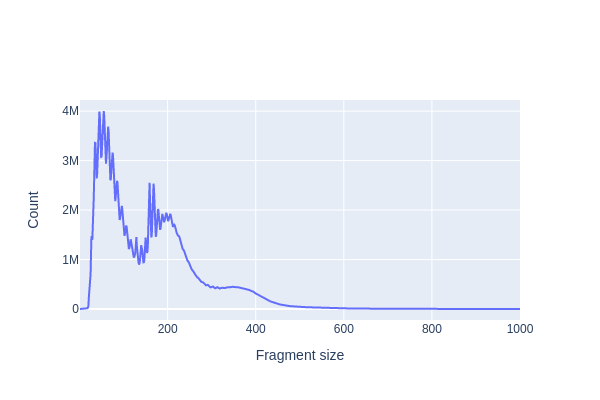

In [41]:
snap.pl.frag_size_distr(data, interactive=False)

In [42]:
%%time
snap.metrics.tsse(data, snap.genome.mm10)

CPU times: user 13min 37s, sys: 18 s, total: 13min 55s
Wall time: 30.8 s


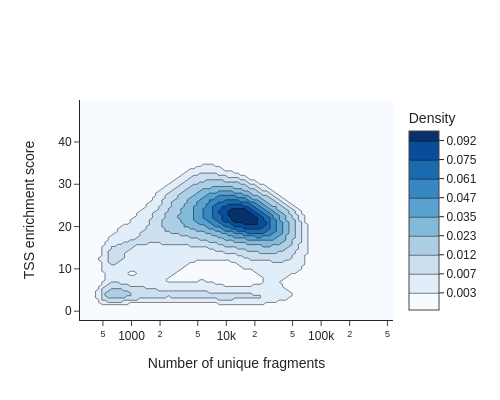

In [43]:
snap.pl.tsse(data, interactive=False)

In [44]:
%%time
snap.pp.filter_cells(data, min_counts=2000, min_tsse=10, max_counts=100000)
data

CPU times: user 2.47 s, sys: 1.1 s, total: 3.57 s
Wall time: 3.57 s


AnnData object with n_obs × n_vars = 28876 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [49]:
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2025-05-12 04:02:43 - INFO - Detected doublet rate = 18.663%


AnnData object with n_obs × n_vars = 23487 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

... storing 'leiden' as categorical


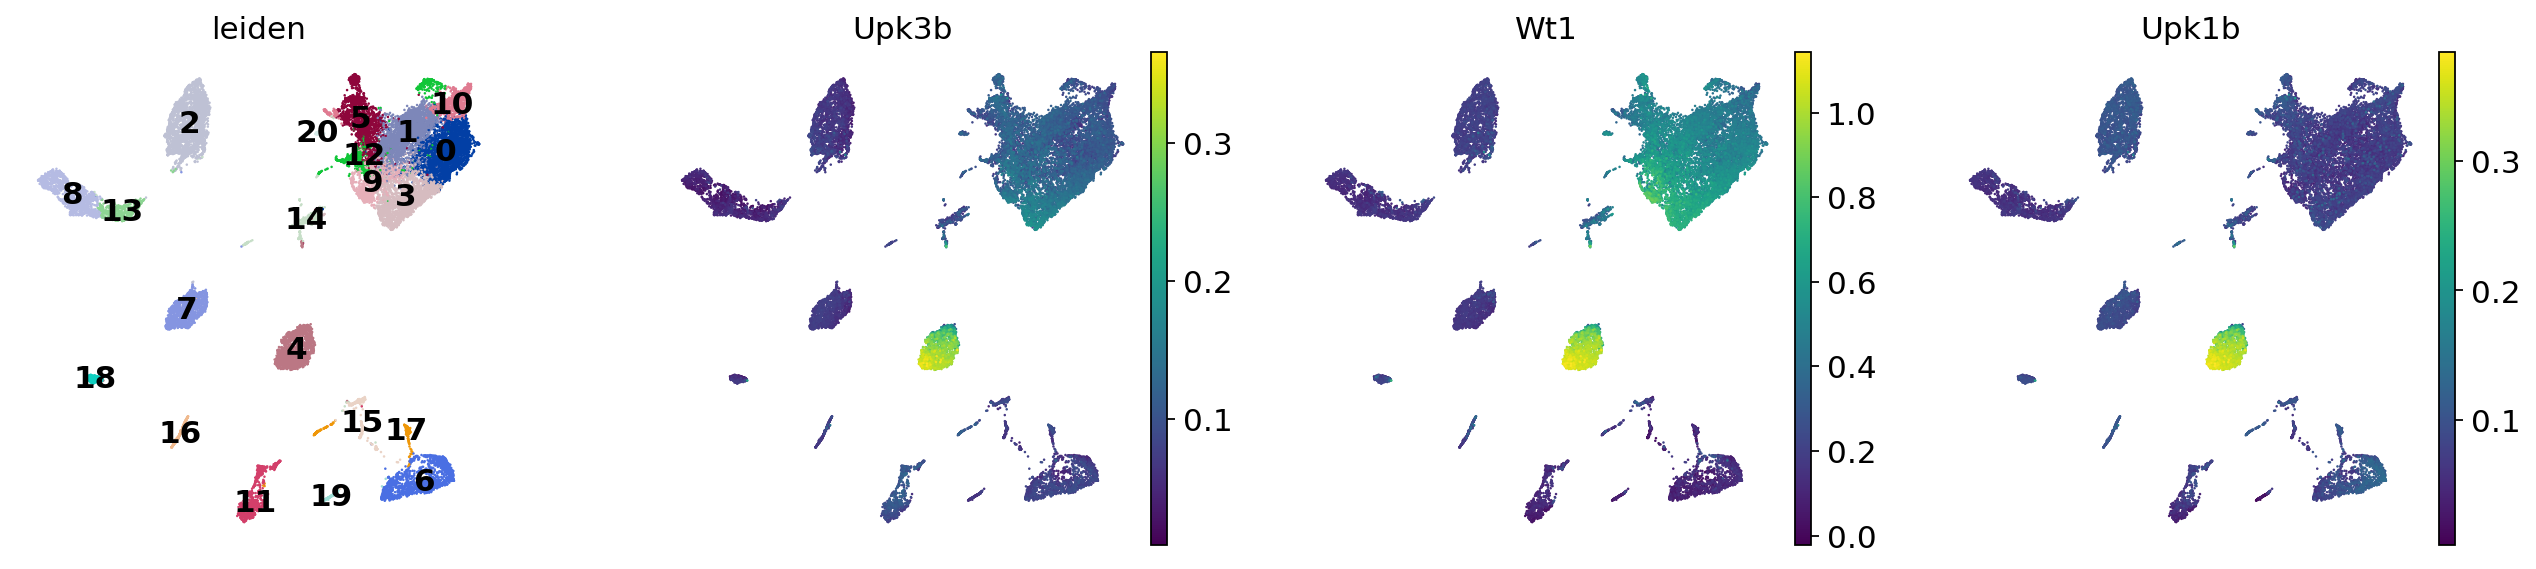

CPU times: user 19min 57s, sys: 23.5 s, total: 20min 21s
Wall time: 5min 42s


In [50]:
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)
gene_matrix

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
marker_genes = ['Upk3b','Wt1','Upk1b']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data')

In [51]:
data.write('mouse_e175_pancreas.h5ad')
gene_matrix.write("mouse_e175_pancreas_gene_mat.h5ad", compression='gzip')

... storing 'leiden' as categorical


In [52]:
meso = data[data.obs['leiden'].isin(['4'])]
meso

View of AnnData object with n_obs × n_vars = 1740 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [53]:
%%time
snap.tl.spectral(meso)
snap.tl.umap(meso)
gene_matrix2 = snap.pp.make_gene_matrix(meso, snap.genome.mm10, count_frag_as_reads=False)
sc.external.pp.magic(gene_matrix2, solver="approximate")
meso.write('mouse_e175_pancreas_meso_only.h5ad')
gene_matrix2.write("mouse_e175_pancreas_meso_only_gene_mat.h5ad", compression='gzip')

CPU times: user 2min 8s, sys: 7.35 s, total: 2min 15s
Wall time: 1min 1s


# Below is the analysis of the lung ATAc-seq samples. We demonstrate our workflow by providing code for analysing the E17.5 lung ATAC-seq sample from this paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC8188567

In [3]:
%%time
# I shall use the on-memory approach for anndata object, rather than the backed (on disk) mode
data = snap.pp.import_data(
    'GSM4763867_E17-5-8_scATAC-seq_fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 3min 8s, sys: 3.51 s, total: 3min 11s
Wall time: 1min 10s


AnnData object with n_obs × n_vars = 5584 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2025-05-23 05:25:42 - INFO - Computing fragment size distribution...


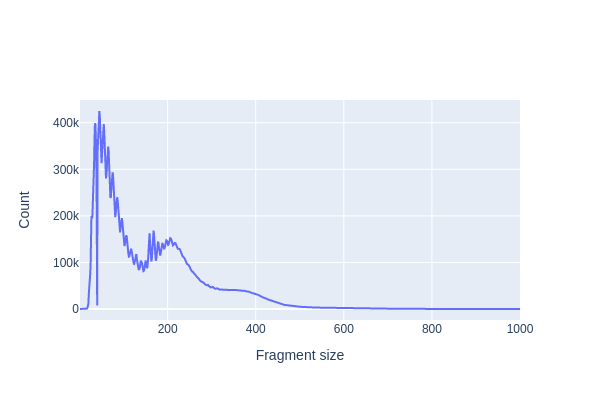

In [4]:
snap.pl.frag_size_distr(data, interactive=False)

In [6]:
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [7]:
%%time
snap.pp.filter_cells(data, min_counts=3000, min_tsse=10, max_counts=100000)
data

CPU times: user 257 ms, sys: 153 ms, total: 410 ms
Wall time: 413 ms


AnnData object with n_obs × n_vars = 2960 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [11]:
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2025-05-23 05:29:06 - INFO - Detected doublet rate = 3.176%


AnnData object with n_obs × n_vars = 2866 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [13]:
%%time
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
marker_genes = ['Upk3b','Wt1','Upk1b']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data')

... storing 'leiden' as categorical


CPU times: user 2min 37s, sys: 7.07 s, total: 2min 44s
Wall time: 50.1 s


In [14]:
data.write('mouse_e175_lung_atac_sample1.h5ad')

... storing 'leiden' as categorical


In [15]:
gene_matrix.write("mouse_e175_lung_atac_sample1_gene_mat.h5ad", compression='gzip')

# Analyze P3 lung sample from this paper: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149563

In [4]:
%%time
# I shall use the on-memory approach for anndata object, rather than the backed (on disk) mode
data = snap.pp.import_data(
    'GSM4504968_P3_atac_fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 11min 53s, sys: 19.1 s, total: 12min 12s
Wall time: 4min 16s


AnnData object with n_obs × n_vars = 13243 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2025-05-24 05:18:55 - INFO - Computing fragment size distribution...


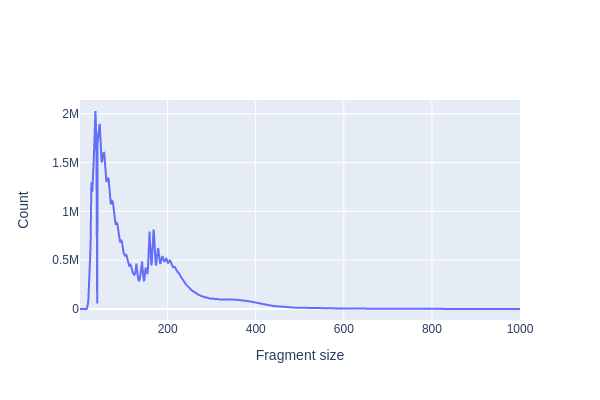

In [5]:
snap.pl.frag_size_distr(data, interactive=False)

CPU times: user 4min 2s, sys: 8.05 s, total: 4min 10s
Wall time: 11.8 s


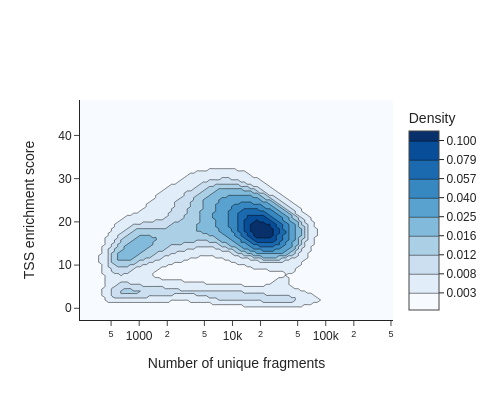

In [6]:
%%time
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [7]:
snap.pp.filter_cells(data, min_counts=4000, min_tsse=10, max_counts=100000)
data

AnnData object with n_obs × n_vars = 8001 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [8]:
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2025-05-24 05:21:03 - INFO - Selected 246960 features.
2025-05-24 05:21:06 - INFO - Simulating doublets...
2025-05-24 05:21:10 - INFO - Spectral embedding ...
2025-05-24 05:23:39 - INFO - Calculating doublet scores...
2025-05-24 05:23:42 - INFO - Detected doublet rate = 6.524%


AnnData object with n_obs × n_vars = 7479 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [9]:
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
marker_genes = ['Upk3b','Wt1','Upk1b']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data')

... storing 'leiden' as categorical


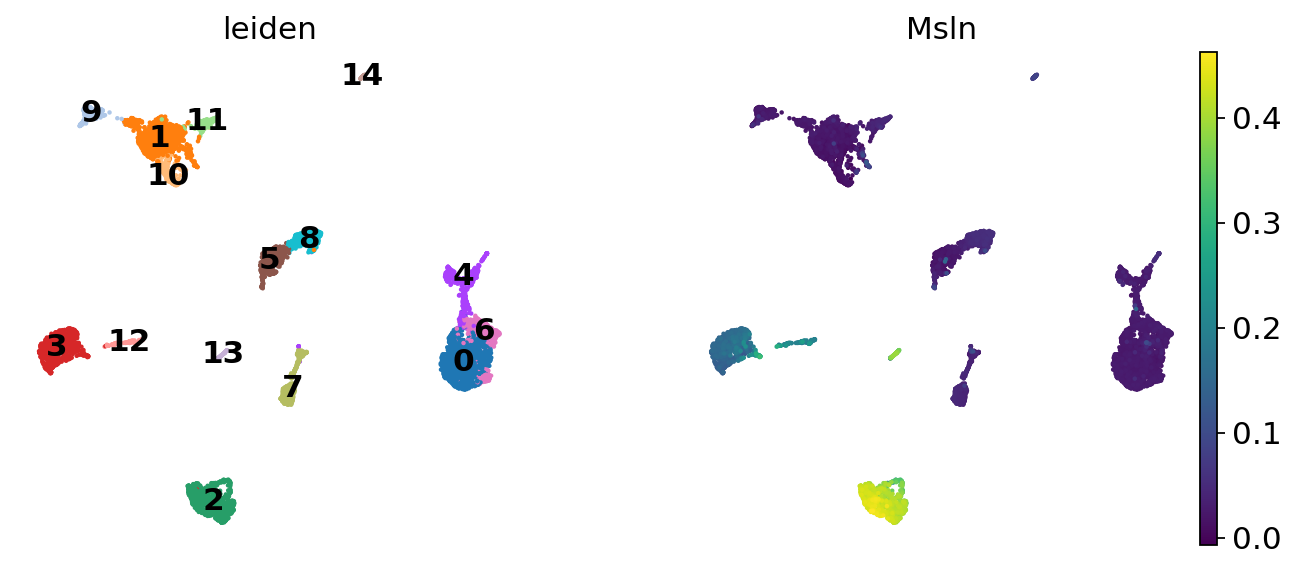

In [13]:
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + ['Msln'], legend_loc='on data')

In [10]:
meso = data[data.obs['leiden'].isin(['13'])]
meso

View of AnnData object with n_obs × n_vars = 84 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [14]:
import pandas as pd
pd.DataFrame(meso.obs).to_csv("p3_lung_meso.tsv", sep="\t")

In [11]:
data.write('mouse_p3_lung_atac.h5ad')

... storing 'leiden' as categorical


# Analyze the E13.5 lung sample from this paper: https://www.sciencedirect.com/science/article/pii/S2211124723002218

In [6]:
%%time
data = snap.pp.import_data(
    '/mnt/sdb/qdang/singlecell/mesothelium/lung/PMID_36881507_embryoatlas/atac/E135_lung2/outs/fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 19min 1s, sys: 27.1 s, total: 19min 28s
Wall time: 6min 58s


AnnData object with n_obs × n_vars = 27734 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [7]:
snap.pl.frag_size_distr(data, interactive=False)

2024-06-06 03:32:11 - INFO - Computing fragment size distribution...


In [8]:
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [10]:
%%time
snap.pp.filter_cells(data, min_counts=4000, min_tsse=10, max_counts=100000)
data

CPU times: user 1.42 s, sys: 665 ms, total: 2.08 s
Wall time: 2.08 s


AnnData object with n_obs × n_vars = 14050 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [15]:
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2024-06-06 03:47:31 - INFO - Detected doublet rate = 17.167%


AnnData object with n_obs × n_vars = 11638 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

In [19]:
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)

sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
snap.pl.umap(data, color='leiden', interactive=False, height=500)

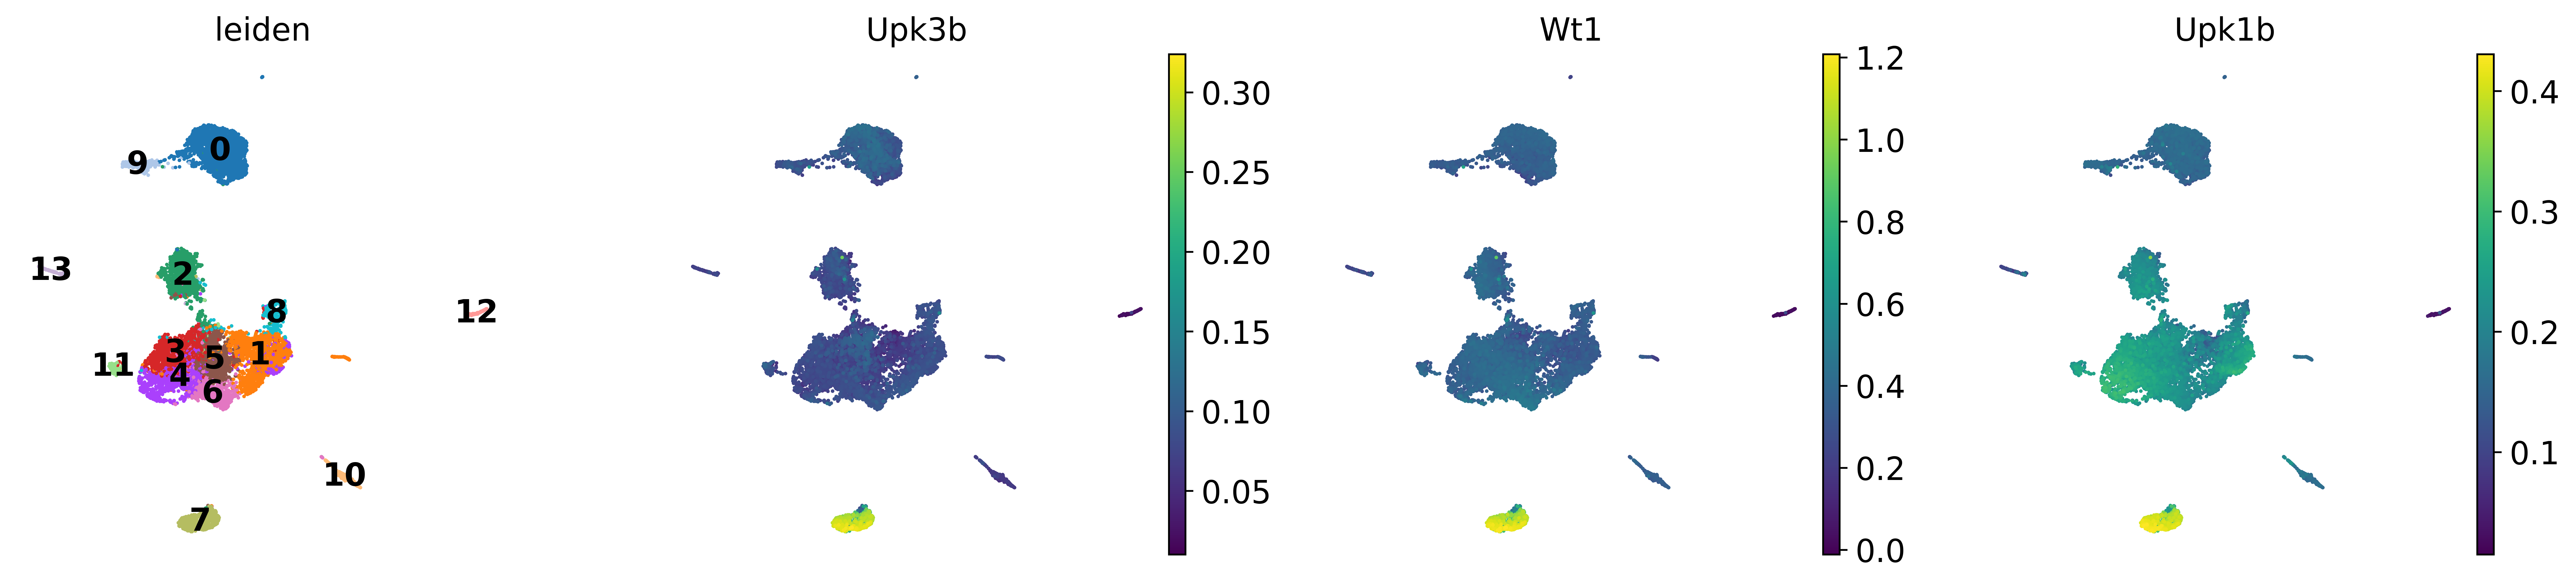

In [13]:
marker_genes = ['Upk3b','Wt1','Upk1b']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data')

In [12]:
meso = data[data.obs['leiden'].isin(['7'])]
meso

View of AnnData object with n_obs × n_vars = 663 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [19]:
meso = sc.read('mouse_e135_lung_meso_only.h5ad')
meso.obs_names

Index(['AAACTCGCATGGTATC-1', 'AAACTCGCATTACCTT-1', 'AAAGGATAGACTTCCA-1',
       'AAAGGGCAGCAATAAC-1', 'AAAGGGCCAACTAGAA-1', 'AAAGGGCGTTCATTTC-1',
       'AAATGAGGTCCGGTAC-1', 'AAATGCCAGCATGTGG-1', 'AAATGCCTCAGTCAAC-1',
       'AACAAAGTCTTGTACT-1',
       ...
       'TTGTTGTTCGAGGCTC-1', 'TTTACGTTCCACCTAC-1', 'TTTGAGGGTTTCCTAT-1',
       'TTTGAGGTCGAGTGTT-1', 'TTTGCGCGTTCCGGCA-1', 'TTTGGCCAGTCTCCAA-1',
       'TTTGGCCTCAGAGTGG-1', 'TTTGGTTAGTAGGTCG-1', 'TTTGGTTCAAGCCCTG-1',
       'TTTGTGTCAGGTCCTG-1'],
      dtype='object', length=663)

# Analyze the E13.5 pancreas ATAC dataset from this paper: https://www.sciencedirect.com/science/article/pii/S2211124723002218

In [17]:
%%time
# I shall use the on-memory approach for anndata object, rather than the backed (on disk) mode
data = snap.pp.import_data(
    'fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 11min 2s, sys: 17.9 s, total: 11min 20s
Wall time: 3min 45s


AnnData object with n_obs × n_vars = 15170 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

2024-06-08 15:29:43 - INFO - Computing fragment size distribution...


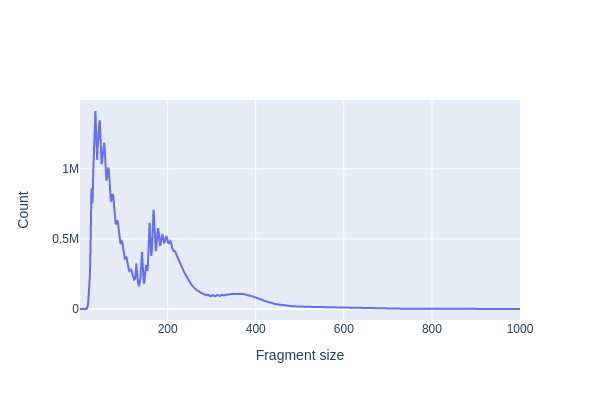

In [6]:
snap.pl.frag_size_distr(data, interactive=False)

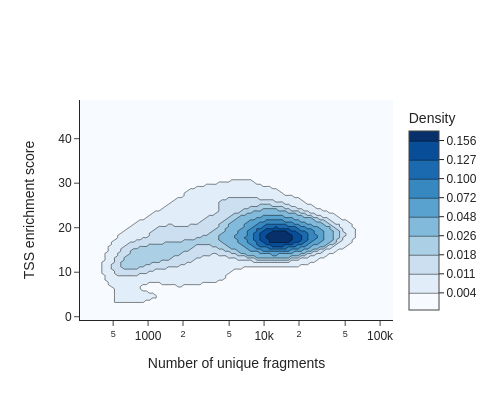

In [9]:
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [10]:
%%time
snap.pp.filter_cells(data, min_counts=4000, min_tsse=10, max_counts=100000)
data

CPU times: user 888 ms, sys: 731 ms, total: 1.62 s
Wall time: 1.63 s


AnnData object with n_obs × n_vars = 9492 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse'
    uns: 'reference_sequences', 'frag_size_distr'
    obsm: 'fragment_paired'

In [14]:
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2024-06-08 15:41:48 - INFO - Detected doublet rate = 14.812%


AnnData object with n_obs × n_vars = 8086 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

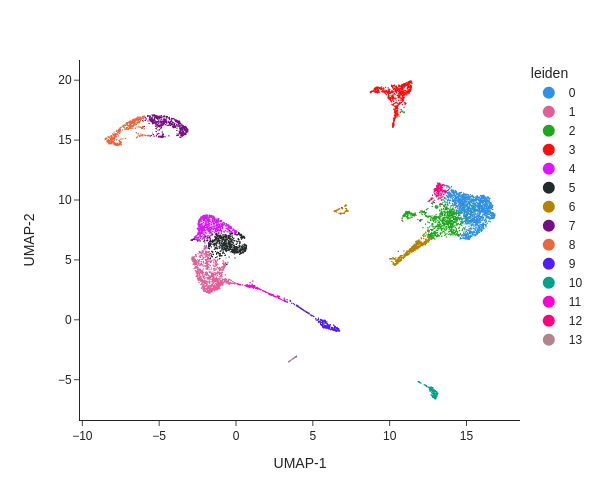

In [18]:
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
snap.pl.umap(data, color='leiden', interactive=False, height=500)

In [19]:
%%time
gene_matrix = snap.pp.make_gene_matrix(data, snap.genome.mm10, count_frag_as_reads=False)
gene_matrix

CPU times: user 2min 44s, sys: 3.05 s, total: 2min 47s
Wall time: 12.5 s


AnnData object with n_obs × n_vars = 8086 × 55291
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'

In [20]:
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]

... storing 'leiden' as categorical


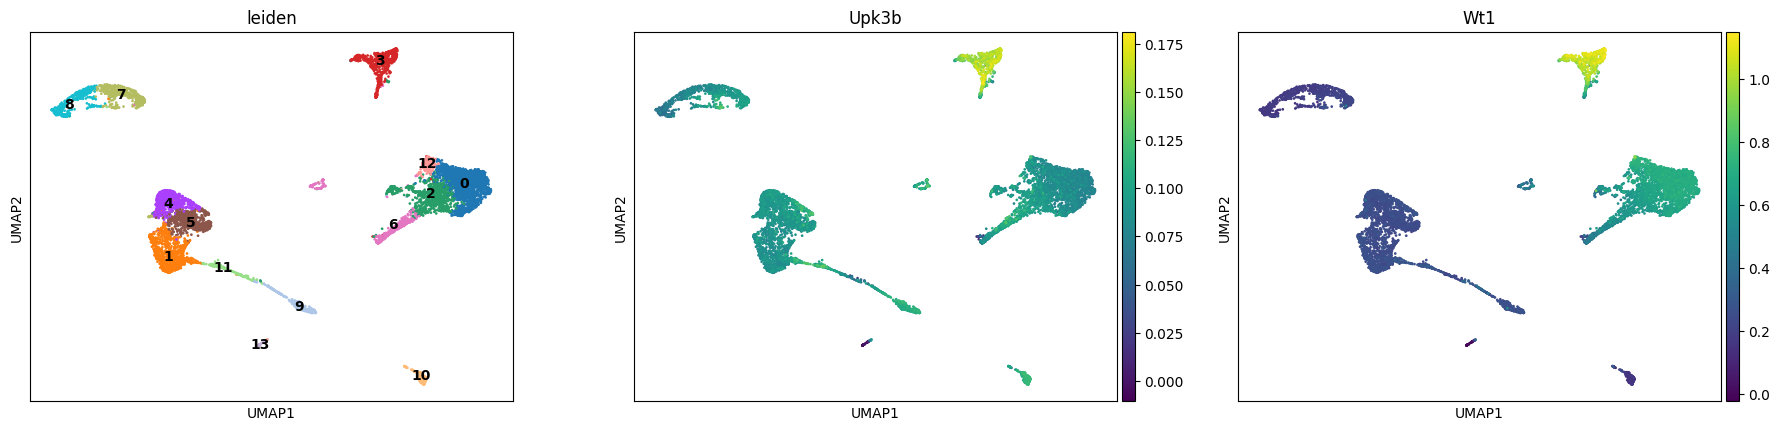

In [23]:
marker_genes = ['Upk3b','Wt1']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc='on data',save='mesothelial_markers.png')

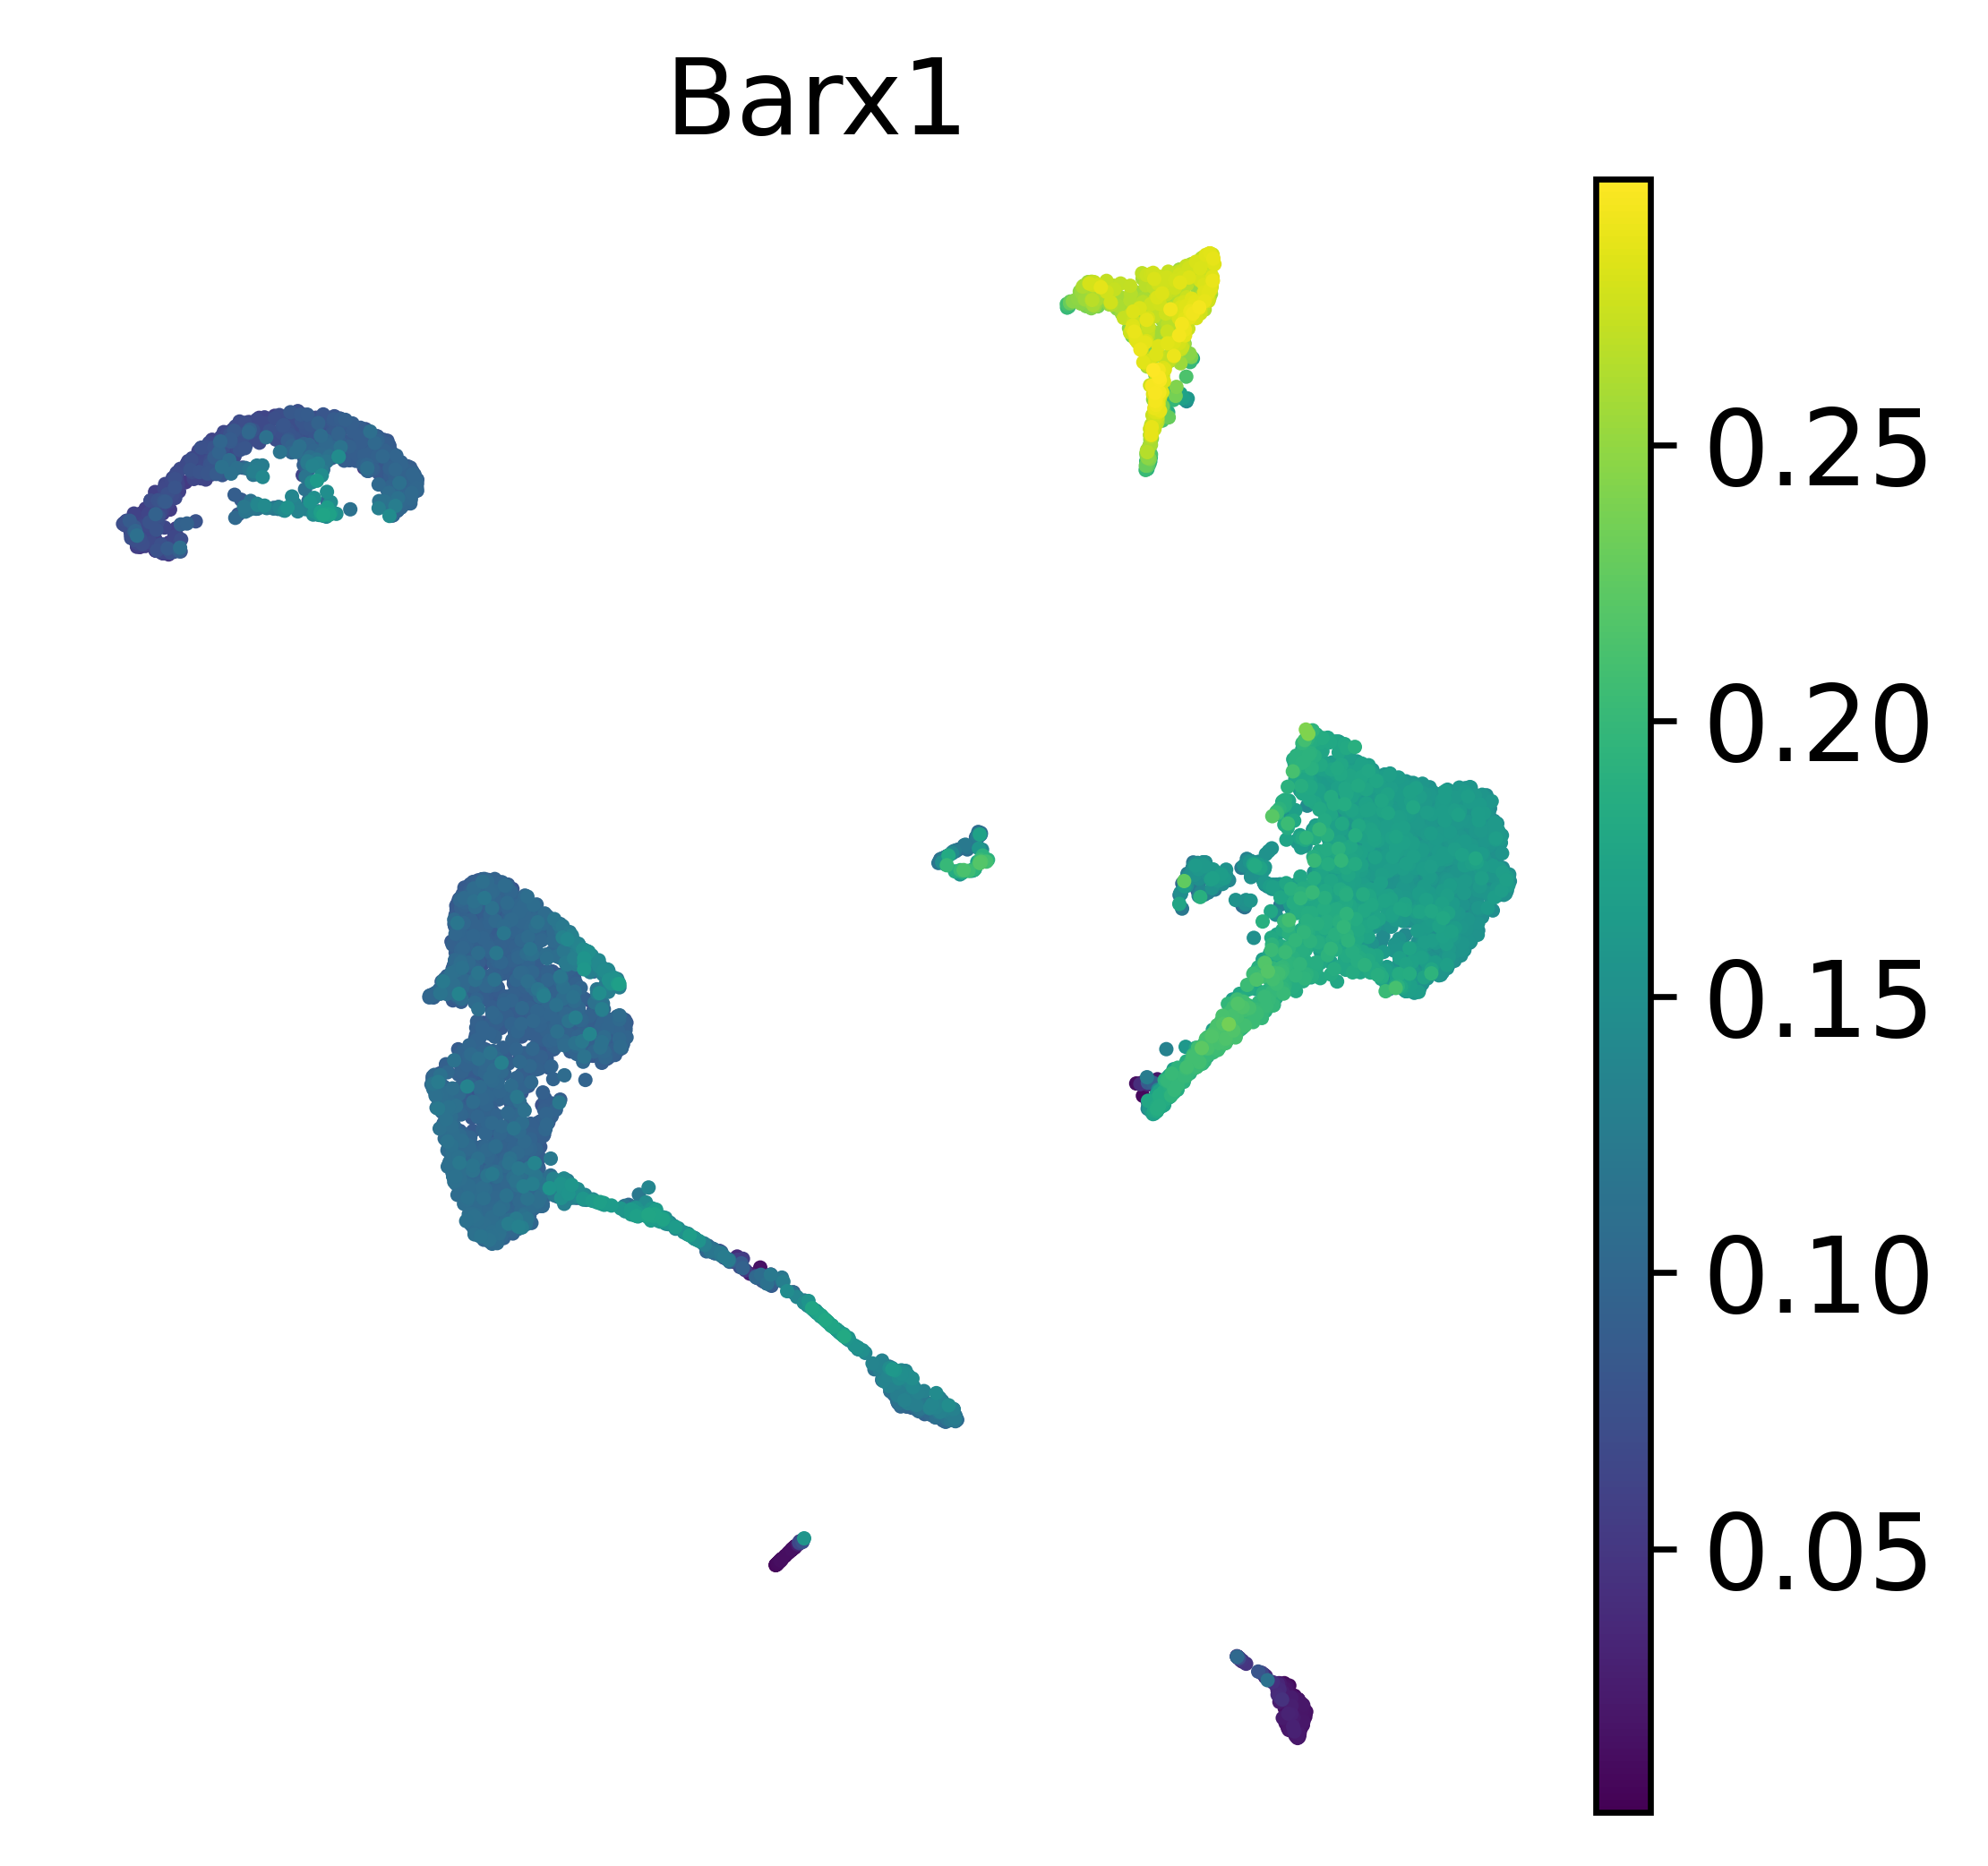

In [31]:
marker_genes = ['Wt1']
sc.pl.umap(gene_matrix, use_raw=False, color='Barx1', legend_loc='on data',save='pancreas_barx1.pdf')

In [29]:
# There are 750 mesothelial cells in the dataset
meso = data[data.obs['leiden'].isin(['3'])]
meso

View of AnnData object with n_obs × n_vars = 750 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

# Below, we are analyzing the E13.5 heart sample from: https://www.sciencedirect.com/science/article/pii/S2211124723002218.

In [12]:
%%time
data = snap.pp.import_data(
    '/mnt/sdb/qdang/atac/sc_atac/E135/fragments.tsv.gz',
    chrom_sizes=snap.genome.mm10,
    sorted_by_barcode=False,
)
data

CPU times: user 7min 53s, sys: 11.5 s, total: 8min 4s
Wall time: 2min 39s


AnnData object with n_obs × n_vars = 49531 × 0
    obs: 'n_fragment', 'frac_dup', 'frac_mito'
    uns: 'reference_sequences'
    obsm: 'fragment_paired'

In [14]:
snap.pl.frag_size_distr(data, interactive=False)

2024-06-20 06:13:08 - INFO - Computing fragment size distribution...


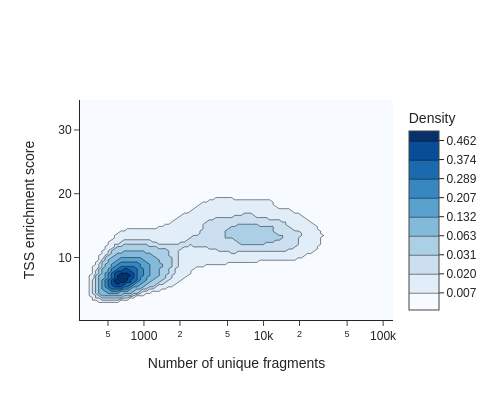

In [16]:
snap.metrics.tsse(data, snap.genome.mm10)
snap.pl.tsse(data, interactive=False)

In [21]:
snap.pp.filter_cells(data, min_counts=3000, min_tsse=10, max_counts=100000)
snap.pp.add_tile_matrix(data)
snap.pp.select_features(data, blacklist='/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed', n_features=250000)
snap.pp.scrublet(data)
snap.pp.filter_doublets(data)
data

2024-06-20 07:10:19 - INFO - Detected doublet rate = 6.680%


AnnData object with n_obs × n_vars = 7292 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate'
    obsm: 'fragment_paired'

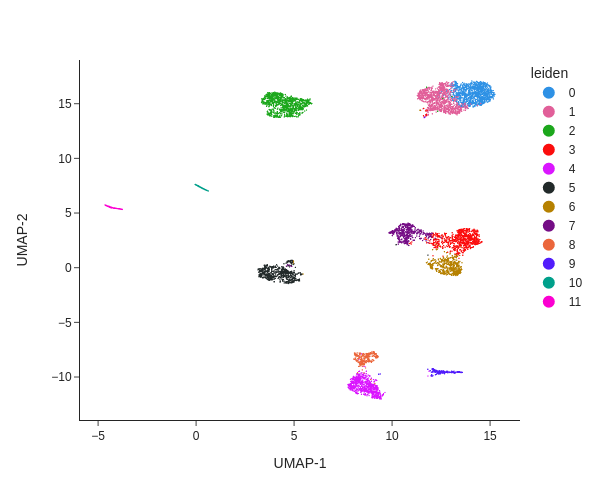

In [25]:
snap.tl.spectral(data)
snap.tl.umap(data)
snap.pp.knn(data)
snap.tl.leiden(data)
snap.pl.umap(data, color='leiden', interactive=False, height=500)

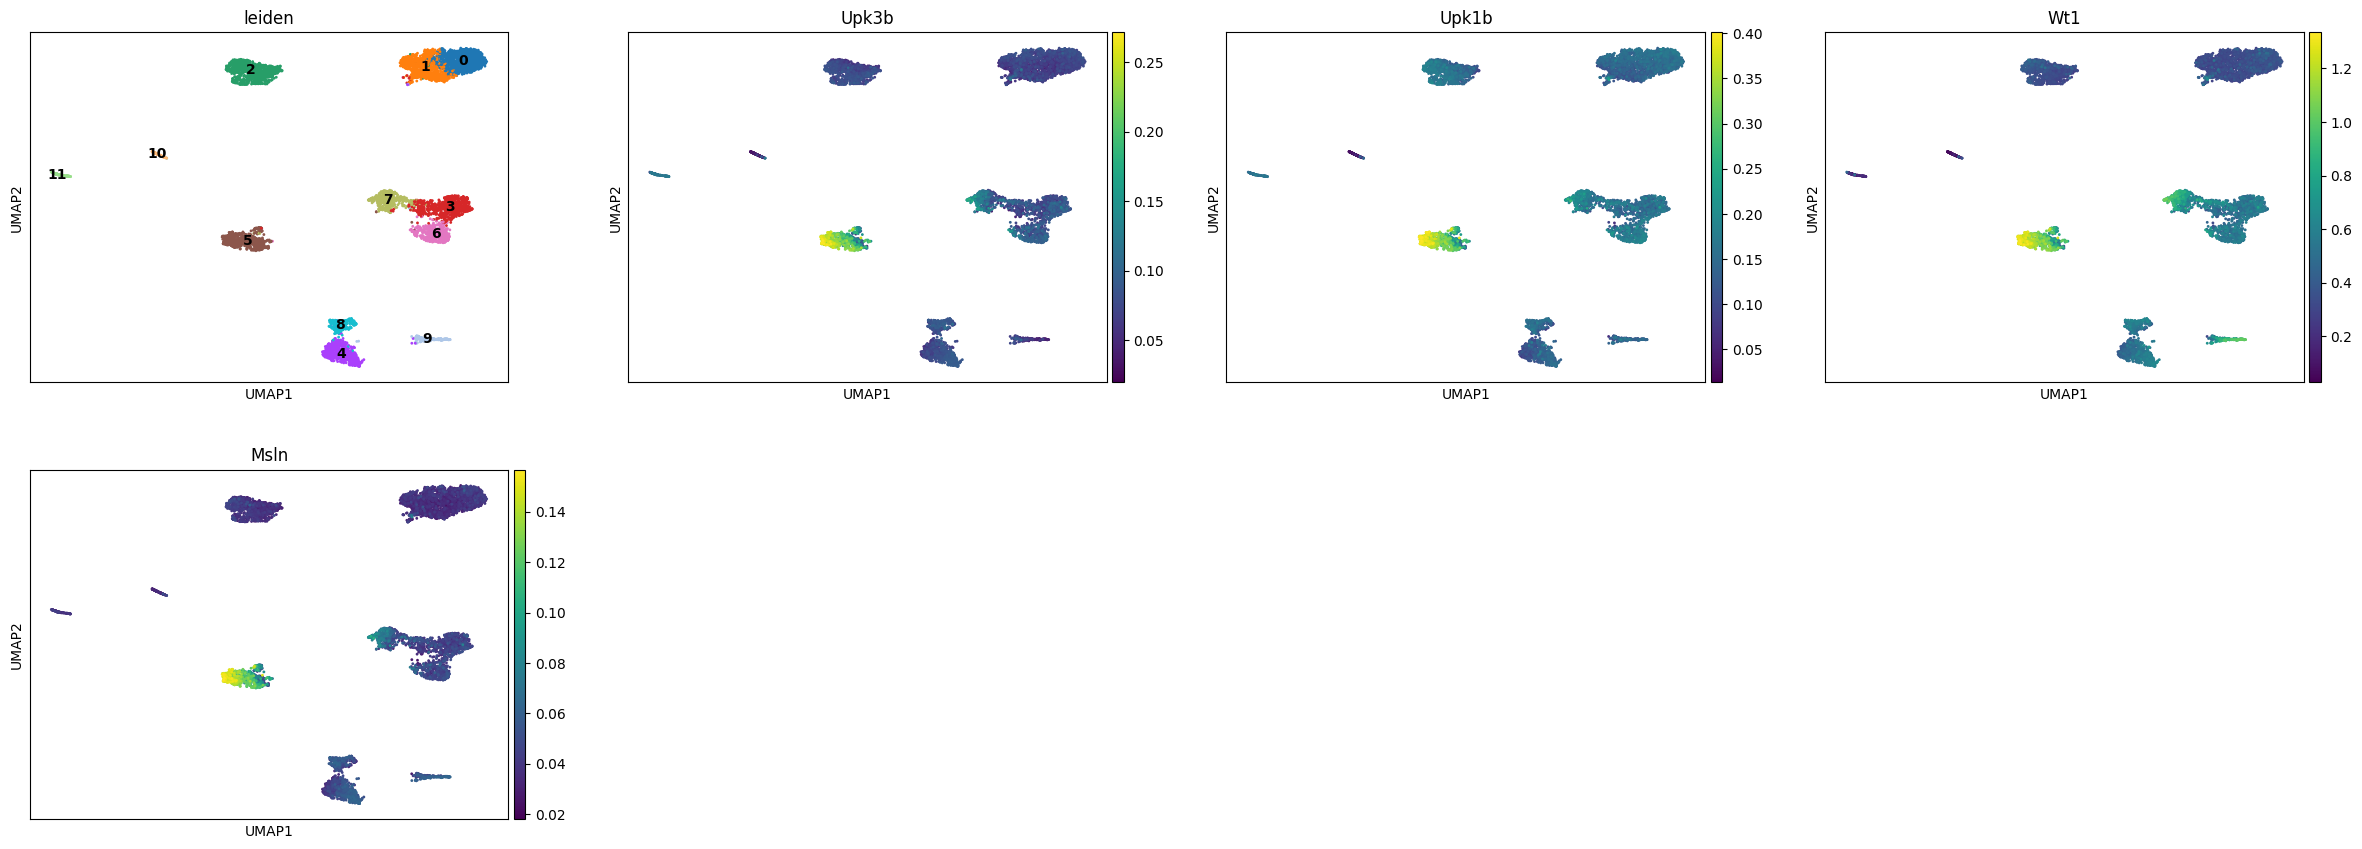

In [33]:
sc.pp.filter_genes(gene_matrix, min_cells= 5)
sc.pp.normalize_total(gene_matrix)
sc.pp.log1p(gene_matrix)
sc.external.pp.magic(gene_matrix, solver="approximate")
gene_matrix.obsm["X_umap"] = data.obsm["X_umap"]
marker_genes = ['Upk3b', 'Upk1b', 'Wt1','Msln']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc = 'on data')

In [34]:
# The epicardium cluster has enriched activity in key marker genes: Upk3b, Upk1b, Msln, and Wt1 
meso = data[data.obs['leiden'].isin(['5'])]
meso

View of AnnData object with n_obs × n_vars = 649 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'reference_sequences', 'frag_size_distr', 'scrublet_sim_doublet_score', 'doublet_rate', 'spectral_eigenvalue'
    obsm: 'fragment_paired', 'X_spectral', 'X_umap'
    obsp: 'distances'

In [10]:
# We identified atrial and ventricular cardiomyocytes from this dataset, marked by enriched activity in Sln and Myl2, respectively
marker_genes = ['Myl2', 'Ttn','Sln']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc = 'on data')

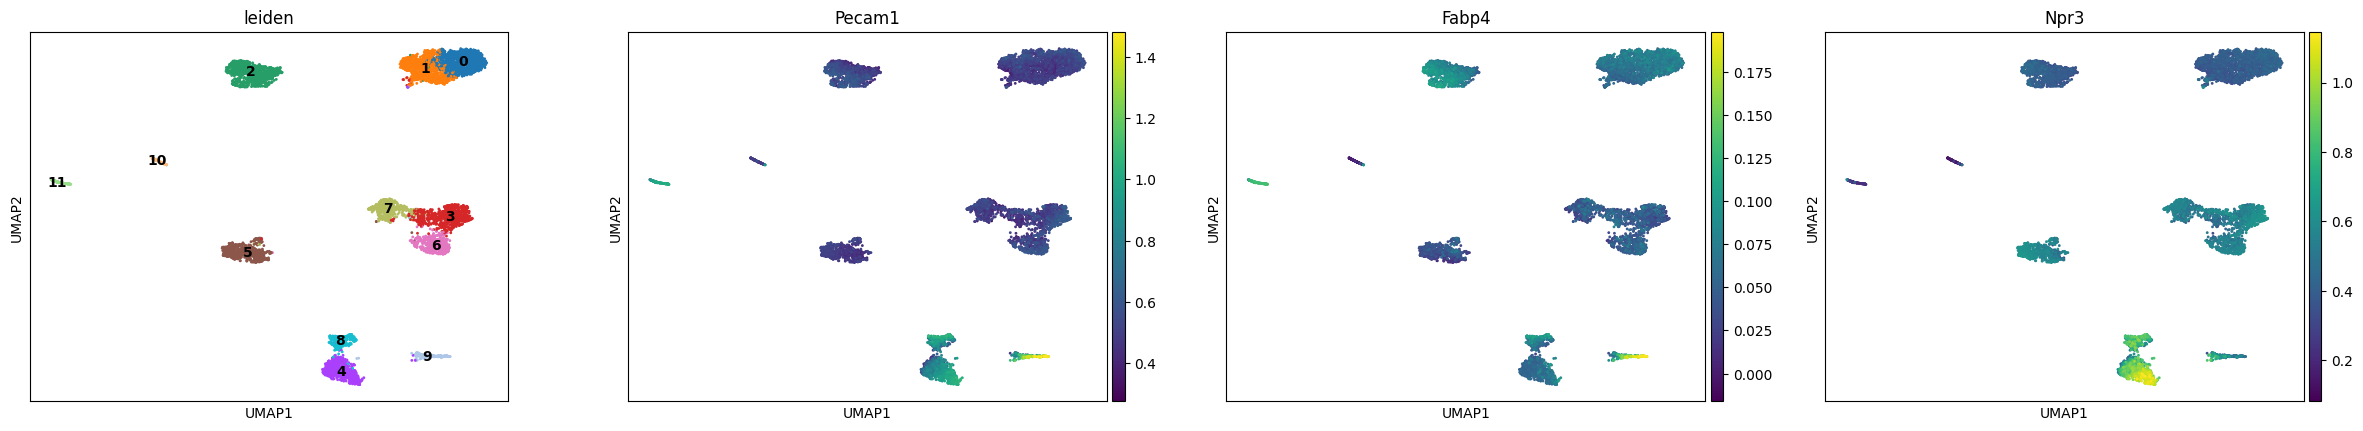

In [12]:
# We identified endocardial and vascular endothelial cells from this dataset, marked by enriched activity in Fabp4 and Npr3, respectively
marker_genes = ['Pecam1', 'Fabp4','Npr3']
sc.pl.umap(gene_matrix, use_raw=False, color=["leiden"] + marker_genes, legend_loc = 'on data')

In [13]:
cm = adata[adata.obs['leiden'].isin(['0','1'])]
cm

View of AnnData object with n_obs × n_vars = 2262 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [14]:
ec = adata[adata.obs['leiden'].isin(['9'])]
ec

View of AnnData object with n_obs × n_vars = 216 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'

In [26]:
meso = adata[adata.obs['leiden'].isin(['5'])]
meso

View of AnnData object with n_obs × n_vars = 649 × 5267565
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'tsse', 'doublet_probability', 'doublet_score', 'leiden'
    var: 'count', 'selected'
    uns: 'doublet_rate', 'frag_size_distr', 'reference_sequences', 'scrublet_sim_doublet_score', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap', 'fragment_paired'
    obsp: 'distances'